In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

We follow the procedure outlined in 3.1.2.1 (Experiment 1)

Currently: 

* $n \in \{12, \dots, 16 \}$
* $k = 8$
* $p \in \{1, 2, 4, 8, 16\}$
* training instances = $100$
* evaluation instances = $1000$


Step 1: Generation of $\underline{\beta}, \underline{\gamma} \in \mathbb{R}^p$

In [33]:
from benchmark.random_problem import RandomProblem

# Read in 100 randomly generated CNF(12, 8, r_8) instances
num_instances = 100
n = 12
k = 8
ps = [1, 2, 4, 8, 16]

rp = RandomProblem(type='ksat')
instances = rp.from_poisson(n=n, k=k, instances=num_instances, from_file=True, calc_naive=True)

In [ ]:
import torch
import h5py
from k_sat.pytorch_solver.pytorch_circuit import PytorchCircuit
from k_sat.pytorch_solver.pytorch_optimiser import PytorchOptimiser

optimal_params = {}

for p in ps:
	print(f'Training for p = {p}')
	circuit = PytorchCircuit(num_vars=n, layers=p)
	adam = torch.optim.Adam(circuit.parameters(), lr=0.1, maximize=True)
	epochs = 40 if p < 5 else 60
	optimiser = PytorchOptimiser(circuit, adam, epochs=epochs)
	optimiser.find_optimal_params(instances.formulas)
	# Save to file
	parent_dir = os.path.dirname(os.getcwd())
	dir = f"{parent_dir}/benchmark/instances/n_{n}"
	with h5py.File(f'{dir}/a_params_{p}.hdf5', 'w') as file:
		file.create_dataset(f'gamma', data=circuit.gamma.detach().clone())
		file.create_dataset(f'beta', data=circuit.beta.detach().clone())

Step 2: Evaluate on satisfiable CNF instances

In [ ]:
import h5py
import torch

# Read params in from file
parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/benchmark/instances/n_{n}"
optimal_params_r = {}
for p in ps:
	with h5py.File(f'{dir}/a_params_{p}.hdf5', 'r') as file:
		gamma = torch.from_numpy(file.get(f'gamma')[:])
		beta = torch.from_numpy(file.get(f'beta')[:])
		optimal_params_r[p] = (gamma, beta)

In [ ]:
from k_sat.pytorch_solver.pytorch_circuit import PytorchCircuit
import json

k_e = k
n_e = [i for i in range(16, 20)]
num_instances_e = 1000

p_succ = {n : {} for n in n_e}

for n in n_e:
	print(f'evaluating n = {n}')

	# Read in random problems
	instances_e = rp.from_poisson(n=n, k=k, instances=num_instances_e, from_file=num_instances, calc_naive=True)

	for (p, params) in optimal_params_r.items():
		print(f'evaluating p = {p}')

		# Initialise QAOA circuit
		circuit = PytorchCircuit(n, p, params[0], params[1])

		# Evolve each instance and take mean of p_succ
		prob = 0
		for instance in instances_e.formulas:
			h = instance.naive_counts
			hS = instance.naive_sats
			prob += circuit(h, hS).item()

		prob = prob / num_instances_e
		
		p_succ[n][p] = prob

		# Save to file
		parent_dir = os.path.dirname(os.getcwd())
		dir = f"{parent_dir}/benchmark/exp1"
		with open(f'{dir}/p_succ.json', 'r') as f:
			data = json.load(f)

		data[str(n)][p] = prob

		with open(f'{dir}/p_succ.json', 'w') as f:
			json.dump(data, f)

<Figure size 1500x1000 with 0 Axes>

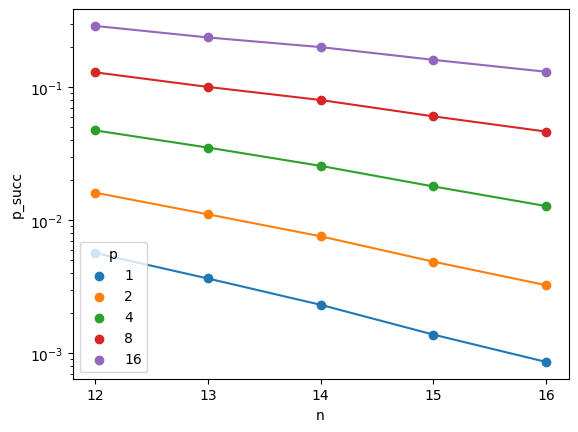

In [31]:
import json
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/benchmark/exp1"

# Load the JSON data from file
with open(f'{dir}/p_succ.json', 'r') as f:
    data = json.load(f)

# Extract the x-axis data
x = list(data.keys())[:5]

# Extract the y-axis data and legend data
y_data = []
legend_data = []
for p in ps[:5]:
	legend_data.append(p)
	y_data.append([data[key][str(p)] for key in x])

# Create the plot
fig, ax = plt.subplots()
for i, legend in enumerate(legend_data):
    ax.scatter(x, y_data[i], label=legend)
    ax.plot(x, y_data[i])
ax.set_yscale('log')
ax.set_xlabel('n')
ax.set_ylabel('p_succ')
ax.legend(title='p')
plt.show()
